# Определение возраста покупателей

# Постановка задачи

Заказчик исследования - сетевой супермаркет «Хлеб-Соль». Заказчик внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.
Задача - построить модель, которая по фотографии определит приблизительный возраст человека. В качестве датасета для обучения модели - набор фотографий людей с указанием возраста.

# Исследовательский анализ данных

## Импорт библиотек и датасета
Импортируем необходимые библиотеки и датасет.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


## Первичное исследование данных
### Оценка датасета

В датасете две колонки: 
* имя файла
* возраст человека

Пропусков и выбросов нет. Тип данных в колонке 'age' целочисленный, это оптимально.

Разброс данных по возрасту от 1 до 100 лет. Данные распределены не вполне равномерно, 75% данных приходится на возраст до 40 лет, два пиковых значения приходятся на 25 и 30 лет. Возможно, это повлияет на результат обучения модели.

Кроме того, видим локальные пики на возрастах: 1, 40, 50, 60, 70, 80, 90 лет. Возможно, составитель датасета не знал реального возраста человека на фото и указывал примерное значение.
    
Датасет загружен и пригоден к исследованию.

In [3]:
def overall_info(df):
    print('Shape:')
    print(df.shape)
    print()
    print('Head:')
    display(df.head())
    print()
    print('Describe df:')
    display(df.describe())
    print(); print()
    print(df.info())
    print(); print()
    print('Nan values:')
    display(df.isna().mean())
    print('Distributions of numerical values:')
    df.hist(figsize=(27, 9), bins=100)

Shape:
(7591, 2)

Head:


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17



Describe df:


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


Nan values:


file_name    0.0
real_age     0.0
dtype: float64

Distributions of numerical values:


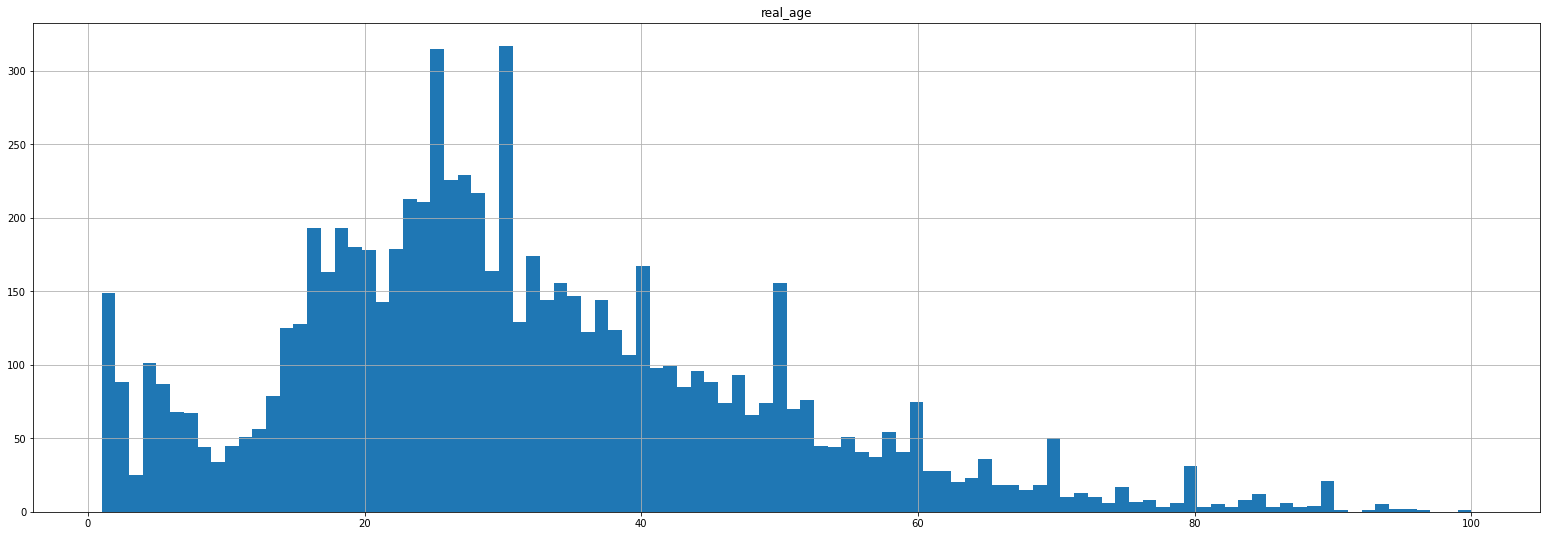

In [4]:
overall_info(labels)

In [5]:
def print_hist_for_one_column(xtitle='Распределение по оси Х', 
                              ytitle='Объекты датасета',
                              df=labels, column_name='real_age',
                              title='График распределения по возрастам', 
                              figsize=(27, 9), bins=100):
    
    
    ax = df[column_name].hist(bins=bins, figsize=figsize)
    ax.set_title(title)
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)

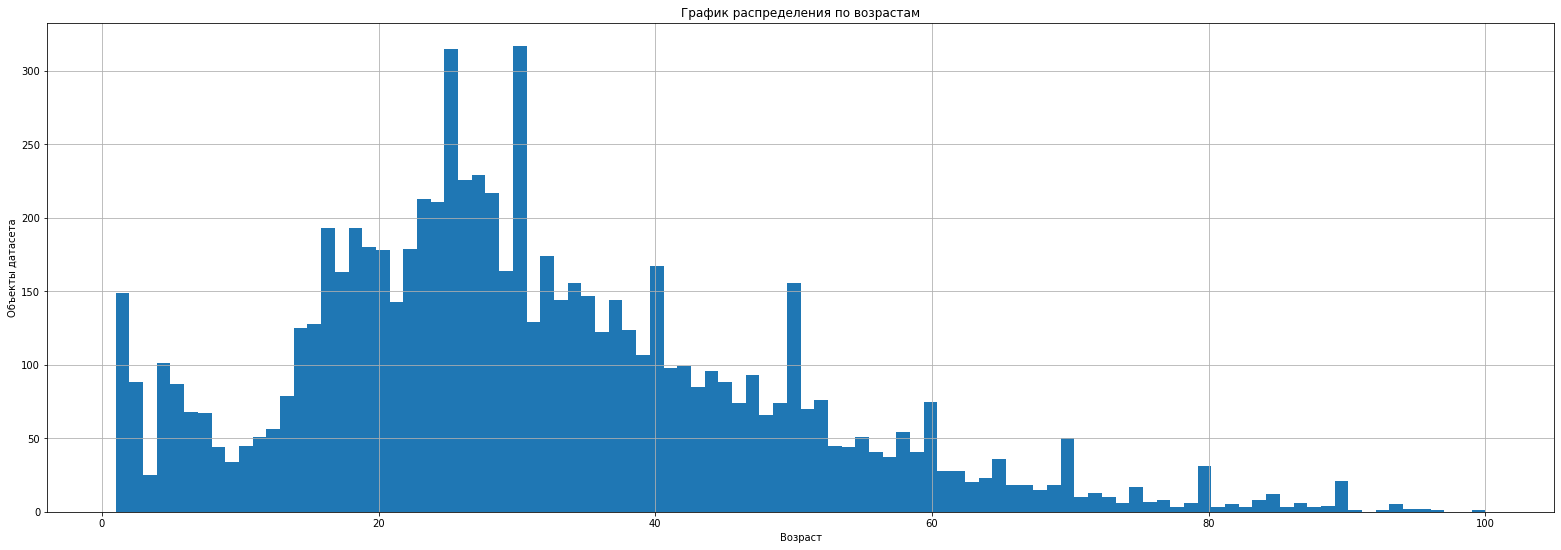

In [6]:
print_hist_for_one_column(xtitle='Возраст')

In [7]:
labels['real_age'].value_counts().head(30)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
22    179
20    178
32    174
40    167
29    164
17    163
34    156
50    156
1     149
35    147
37    144
33    144
21    143
31    129
15    128
14    125
38    124
36    122
39    107
4     101
Name: real_age, dtype: int64

### Ознакомление с содержимым датасета
Выведем на экран несколько изображений из датасета.

In [8]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
datagen = ImageDataGenerator(validation_split=0.25,
                             rescale=1./255,
                            )
datagen_flow = datagen.flow_from_directory(
    '/datasets/faces/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='training',
    seed=666)

features, target = next(datagen_flow)

Found 5694 images belonging to 1 classes.


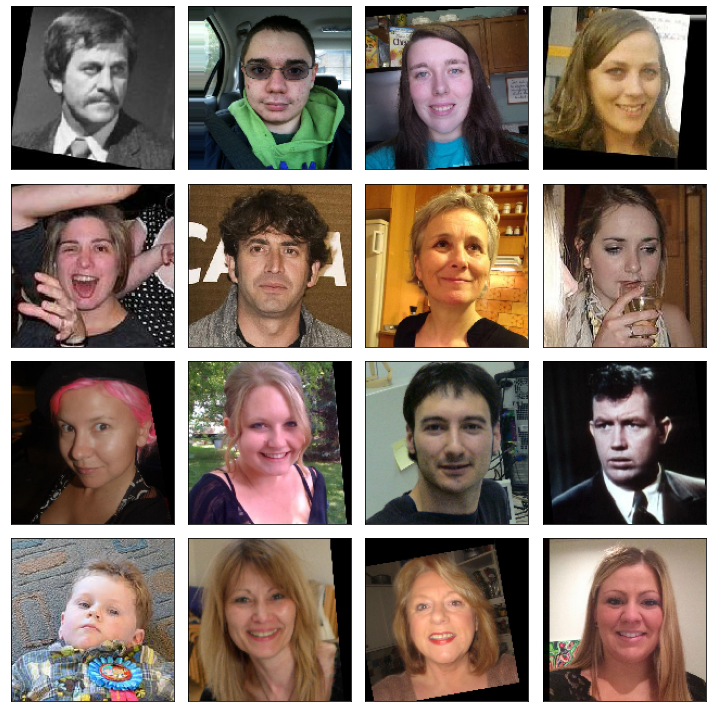

In [10]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Проверим, содержит ли датасет черно-белые файлы. Среди первой сотни картинок есть три черно-белые, остальные цветные. Значит, ч/б картинки есть.

In [11]:
from PIL import Image,ImageChops

In [12]:
def isgray(imgpath):
    img_pil = Image.open(imgpath)
    img = np.asarray(img_pil)
    if len(img.shape) < 3: return True
    if img.shape[2]  == 1: return True
    r,g,b = img[:,:,0], img[:,:,1], img[:,:,2]
    if np.allclose(r,g) and np.allclose(r,b): return True
    return False

In [13]:
path = '/datasets/faces/final_files/'
labels['image_path'] = path + labels['file_name']
labels.head()

,file_name,real_age,image_path
0,000000.jpg,4,/datasets/faces/final_files/000000.jpg
1,000001.jpg,18,/datasets/faces/final_files/000001.jpg
2,000002.jpg,80,/datasets/faces/final_files/000002.jpg
3,000003.jpg,50,/datasets/faces/final_files/000003.jpg
4,000004.jpg,17,/datasets/faces/final_files/000004.jpg


In [14]:
#labels['is_gray'] = labels['image_path'].apply(isgray)
gray_results = []

for path in labels['image_path'].head(100):
    gray_results.append(isgray(path))

In [15]:
gray_results.count(True)

3

Проверим размеры картинок. Видим, что размеры картинок самые разные, единого стандарта нет.

In [16]:
def get_shape(fname):
    img=Image.open(fname)
    return (img.size[0], img.size[1])

In [17]:
image_sizes = []

for path in labels['image_path'].head(100):
    image_sizes.append(get_shape(path))

In [18]:
image_sizes

[(114, 114),
 (784, 784),
 (133, 133),
 (370, 370),
 (212, 212),
 (637, 636),
 (412, 412),
 (311, 311),
 (897, 898),
 (724, 724),
 (636, 636),
 (803, 803),
 (155, 155),
 (321, 321),
 (204, 203),
 (320, 321),
 (921, 920),
 (168, 169),
 (212, 212),
 (109, 109),
 (278, 279),
 (286, 286),
 (201, 202),
 (109, 109),
 (307, 307),
 (1657, 1658),
 (513, 514),
 (333, 334),
 (2364, 2364),
 (131, 131),
 (359, 359),
 (219, 219),
 (93, 93),
 (394, 393),
 (145, 146),
 (538, 538),
 (138, 138),
 (677, 678),
 (265, 265),
 (177, 178),
 (404, 404),
 (747, 747),
 (481, 481),
 (308, 308),
 (237, 237),
 (116, 116),
 (449, 449),
 (419, 418),
 (136, 136),
 (240, 240),
 (400, 399),
 (200, 200),
 (286, 286),
 (146, 145),
 (331, 331),
 (381, 381),
 (525, 526),
 (112, 111),
 (353, 353),
 (408, 409),
 (141, 140),
 (418, 418),
 (69, 69),
 (297, 297),
 (615, 615),
 (727, 726),
 (220, 220),
 (200, 133),
 (192, 193),
 (1200, 1200),
 (255, 255),
 (1021, 1021),
 (1522, 1522),
 (628, 629),
 (345, 344),
 (721, 720),
 (356,

### Вывод по содержимому датасета

Датасет содержит черно-белые и цветные картинки. Единого стандарта размера нет. Ориентация картинок вертикальная.

## Обучение модели

Создадим модель для определения возраста людей по фотографии на основе ResNet50 и обучим ее на предоставленном датасете. Датасет импортируем заново.

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

labels = pd.read_csv('/datasets/faces/labels.csv')

def load_train(path):
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        #vertical_flip=True,
        #width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1/255.)



    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        shuffle=True,
        seed=12345)


    return train_datagen_flow


def load_test(path):
    validation_datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1/255.)  

    val_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        shuffle=True,
        seed=12345)
      
    return val_datagen_flow


def create_model(input_shape):


    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)

    # backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001) # 0.001 and default: 0.0001
    model.compile(optimizer=optimizer, loss='mae',
                  metrics=['mae'])

    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=4,
                steps_per_epoch=None, validation_steps=None):


    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)


    return model


```

Результат обучения модели получился следующий. Метрика MAE на тренировочном датасете 5.9370, на валидационном датасете 6.4210.

```
Train for 238 steps, validate for 60 steps
Epoch 1/4
2023-04-23 00:14:22.310550: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-23 00:14:22.770931: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
238/238 - 128s - loss: 10.8010 - mae: 10.7910 - val_loss: 23.6157 - val_mae: 23.6102
Epoch 2/4
238/238 - 119s - loss: 7.3556 - mae: 7.3383 - val_loss: 11.8664 - val_mae: 11.8310
Epoch 3/4
238/238 - 119s - loss: 6.5067 - mae: 6.4850 - val_loss: 7.7470 - val_mae: 7.7434
Epoch 4/4
238/238 - 120s - loss: 5.9552 - mae: 5.9370 - val_loss: 6.4339 - val_mae: 6.4210
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 6.4339 - mae: 6.4210
Test MAE: 6.4210
```



## Анализ обученной модели

Поставленную цель (МАЕ <= 8 на валидации) удалось достичь с помощью модели на основе ResNet50, к которой был добавлен один полносвязный слой с одним нейроном на выходе. Конфигурация сети:

```
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))
```

Использовался оптимайзер Adam(lr=0.0001). Сеть очень быстро обучалась и переобучалась, поэтому число эпох было опытным путем сокращено до четырех. Для инициализации были использованы веса 'imagenet', полученные в результате обучения сети ResNet на датасете ImageNet. Сеть backbone (ResNet из 50 слоев) дообучалась на датасете. Достичь нужного MAE без дообучения backbone на датасете не удалось ни с одним, ни с двумя, ни с тремя добавленными слоями верхушки (top). 

Цель обучения достигнута, MAE на валидационном датасете составляет 6.4210, что означает, что на валидации модель определяет возраст человека по фото со средней погрешностью 6.4 года. 

Стоило бы запустить модель в другом окружении и проверить ее на тестовой выборке, чтоб оценить пригодность для дальнейших шагов по внедрению.